In [1]:
import datetime as dt

import pandas as pd
from sklearn.preprocessing import (
    OneHotEncoder,
)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from analytics.machine_learning.price_prediction_with_fundamentals import utils

In [2]:
dataset = utils.get_features(features_categories=['arctan_pct_change'], target='price_pct_change_next_three_months')

In [3]:
# Create categorical target
bins = [-float('inf'), -0.10, -0.05, 0, 0.05, 0.10, float('inf')]
labels = ['-10-', '-5 to -10', '-5 to 0', '0 to 5', '5 to 10', '10+']

dataset['pct_change_range'] = pd.cut(dataset['price_pct_change_next_three_months'], bins=bins, labels=labels, right=False)

In [4]:
dataset[['price_pct_change_next_three_months', 'pct_change_range']][:20]

,price_pct_change_next_three_months,pct_change_range
0,0.671429,10+
1,-0.329293,-10-
2,0.175758,10+
3,-0.020408,-5 to 0
4,0.032765,0 to 5
5,0.055494,5 to 10
6,-0.033916,-5 to 0
7,0.081433,5 to 10
8,0.100000,10+
9,-0.054836,-5 to -10


In [5]:
dataset['pct_change_range'].value_counts()

10+          15488
-10-         14334
0 to 5        6969
-5 to 0       6276
-5 to -10     5351
5 to 10       4970
Name: pct_change_range, dtype: int64

# Random Forrest

Overall Accuracy: 26.72%


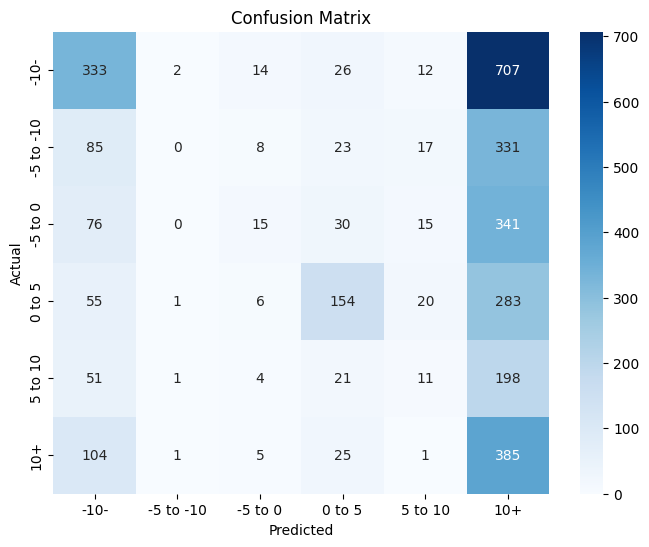

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

dataset = utils.get_features(features_categories=['arctan_pct_change'], target='price_pct_change_next_three_months')

# Create categorical target
bins = [-float('inf'), -0.10, -0.05, 0, 0.05, 0.10, float('inf')]
labels = ['-10-', '-5 to -10', '-5 to 0', '0 to 5', '5 to 10', '10+']

dataset['pct_change_range'] = pd.cut(dataset['price_pct_change_next_three_months'], bins=bins, labels=labels, right=False)

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,6,1)
)

cols_to_drop = ['symbol', 'fiscal_date_ending', 'price_pct_change_next_three_months', 'pct_change_range']
target_col = 'pct_change_range'

y_train = train_set[target_col]
X_train = train_set.drop(cols_to_drop, axis=1)

y_test = test_set[target_col]
X_test = test_set.drop(cols_to_drop, axis=1)

column_transformer = make_column_transformer(
    (
        OneHotEncoder(), ['sector']
    ),
    remainder='passthrough'
)

random_forrest_classifier = RandomForestClassifier(n_estimators=100)
random_forrest = make_pipeline(
    column_transformer,
    random_forrest_classifier
)

random_forrest.fit(X_train, y_train)
y_pred_random_forrest = random_forrest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_random_forrest)
print(f"Overall Accuracy: {accuracy:.2%}")

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_random_forrest, labels=labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# XGBoost

Overall Accuracy: 24.55%


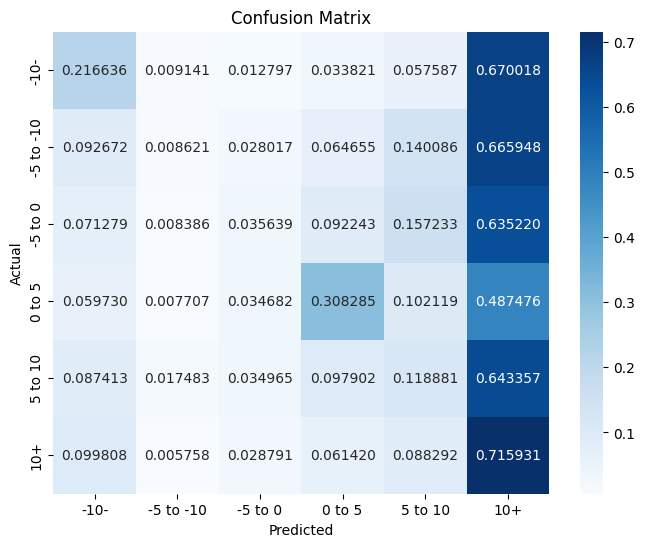

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np


def custom_objective(predt, dtrain):
    label = dtrain.get_label()
    ypred = predt.ravel()
    cost = np.zeros(ypred.shape)

    cost_matrix = np.array([
        [0, 1, 2, 3, 4, 5],  # Costs for misclassifying '-10-' as other classes
        [1, 0, 1, 2, 3, 4],  # Costs for misclassifying '-5 to -10' as other classes
        [2, 1, 0, 1, 3, 4],  # Costs for misclassifying '-5 to 0' as other classes
        [4, 3, 2, 0, 1, 2],  # Costs for misclassifying '0 to 5' as other classes
        [4, 3, 2, 1, 0, 1],  # Costs for misclassifying '5 to 10' as other classes
        [5, 4, 3, 2, 1, 0]   # Costs for misclassifying '10+' as other classes
    ])

    for i in range(len(ypred)):
        for j in range(len(ypred)):
            if label[i] != j:
                cost[i] += cost_matrix[label[i]][j] * ypred[i][j]

    return -np.sum(cost)


dataset = utils.get_features(features_categories=['arctan_pct_change'], target='price_pct_change_next_three_months')

# Create categorical target
bins = [-float('inf'), -0.10, -0.05, 0, 0.05, 0.10, float('inf')]
label_mapping = {0: '-10-', 1: '-5 to -10', 2: '-5 to 0', 3: '0 to 5', 4: '5 to 10', 5: '10+'}
labels = ['-10-', '-5 to -10', '-5 to 0', '0 to 5', '5 to 10', '10+']

dataset['pct_change_range'] = pd.cut(dataset['price_pct_change_next_three_months'], bins=bins, labels=[0,1,2,3,4,5], right=False)

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,6,1)
)

cols_to_drop = ['symbol', 'fiscal_date_ending', 'price_pct_change_next_three_months', 'pct_change_range']
target_col = 'pct_change_range'

y_train = train_set[target_col]
X_train = train_set.drop(cols_to_drop, axis=1)

y_test = test_set[target_col]
X_test = test_set.drop(cols_to_drop, axis=1)

column_transformer = make_column_transformer(
    (
        OneHotEncoder(), ['sector']
    ),
    remainder='passthrough'
)

xgb_classifier = make_pipeline(
    column_transformer,
    xgb.XGBClassifier()
)

xgb_classifier.fit(X_train, y_train)
y_pred_xgb_classifier = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb_classifier)
print(f"Overall Accuracy: {accuracy:.2%}")

y_test = [label_mapping[y] for y in y_test]
y_pred = [label_mapping[y] for y in y_pred_xgb_classifier]
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# KNN

Overall Accuracy: 20.98%


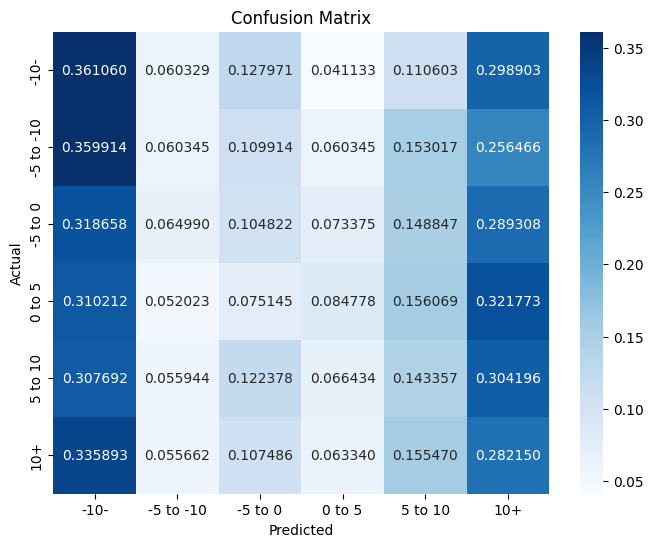

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

dataset = utils.get_features(features_categories=['arctan_pct_change'], target='price_pct_change_next_three_months')

# Create categorical target
bins = [-float('inf'), -0.10, -0.05, 0, 0.05, 0.10, float('inf')]
labels = ['-10-', '-5 to -10', '-5 to 0', '0 to 5', '5 to 10', '10+']

dataset['pct_change_range'] = pd.cut(dataset['price_pct_change_next_three_months'], bins=bins, labels=labels, right=False)

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,6,1)
)

cols_to_drop = ['symbol', 'fiscal_date_ending', 'price_pct_change_next_three_months', 'pct_change_range']
target_col = 'pct_change_range'

y_train = train_set[target_col]
X_train = train_set.drop(cols_to_drop, axis=1)

y_test = test_set[target_col]
X_test = test_set.drop(cols_to_drop, axis=1)

column_transformer = make_column_transformer(
    (
        OneHotEncoder(), ['sector']
    ),
    remainder='passthrough'
)

random_forrest_classifier = KNeighborsClassifier(weights='distance')
random_forrest = make_pipeline(
    column_transformer,
    random_forrest_classifier
)

random_forrest.fit(X_train, y_train)
y_pred_random_forrest = random_forrest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_random_forrest)
print(f"Overall Accuracy: {accuracy:.2%}")

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_random_forrest, labels=labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
